# Data Preparation
<hr>

In [1]:
# Imports
import ast
import json
import random
import re
import sqlite3
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import requests
from faker import Faker
from IPython.display import display

In [2]:
fake = Faker()
fake.seed_instance(42)
np.random.seed(42)

<hr>

## Database Structure Overview


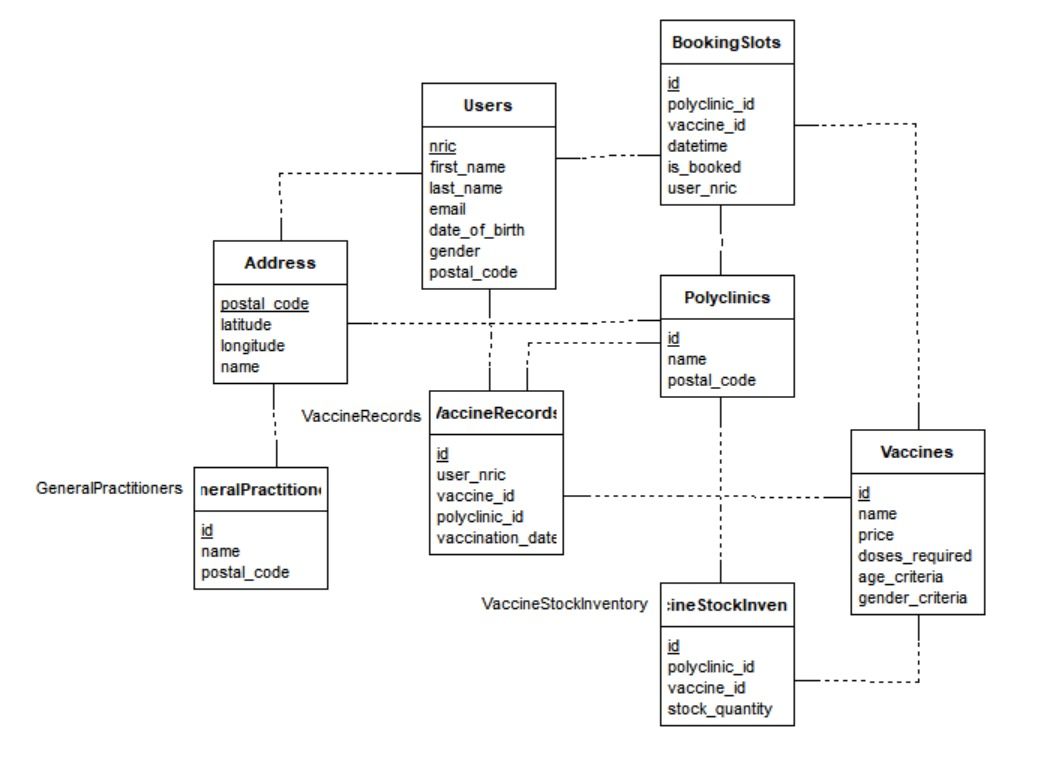

## Methodology

Currently, the Data Owner may provided the real data or a mock data has to be created to replicate a similar data workflow.

Data provided by Data Owner:
1. `Recommended_Vaccination_Workflow` folder

From this provided data, the `Polyclinics` table can be populated with the JSON data from `03_GetInstitutions List`

For mock data generation, there are two ways:

1. Sample data using `faker` library
2. Avaliable open source data

For open source data, there are avaliable platforms such as `data.gov.sg`, `kaggled` and etc.

### **Provided Data by Data Owner**

A `Recommended_Vaccination_Workflow` folder illustrates the workflow to book an appointment based on the recommended vaccination. Inside the folder, there are 6 subfolders, each representing a step in the workflow. In eahc subfolder, there is a `Request.txt` and `Response.txt` which contains the JSON format of the data.

There is a `03_GetInstitutions List`, where its `Response.txt` contains a list of the healthcare/medical institutions in Singapore. It contains information about polyclinics, which can be used to populate the `Polyclinics` table.

In [3]:
# Load the JSON data from the file
with open(
    r"..\data\Vaccination_Workflow 1\Recommended_Vaccination_Workflow\03_Get Institutions List\Response.txt",
    "r",
) as f:
    institutionsData = json.load(f)

In [4]:
# Extract the list of health organizations
health_organizations = institutionsData["Result"]["HealthOrganizations"]

# Normalize the 'Cluster' and 'Group' columns
institutions_df = pd.json_normalize(health_organizations, sep="_")

# Sort the DataFrame by the 'Id' column
institutions_df = institutions_df.sort_values(by="Id")

# Reset the index after sorting
institutions_df = institutions_df.reset_index(drop=True)

print(f"Columns: {institutions_df.columns}\n")
print(f"Unique GroupName: {institutions_df['GroupName'].value_counts()}")
# Display the DataFrame
institutions_df.head(5)

Columns: Index(['Id', 'OrganizationCode', 'Name', 'LogoCode', 'ClusterId',
       'ClusterCode', 'GroupName', 'GroupCode', 'GroupSequence', 'IsDeleted',
       'ContactNumber', 'Address', 'Latitude', 'Longitude', 'OperationHours',
       'Email', 'Sequence', 'ContactCenterOperationHours', 'CreatedOn',
       'UpdatedOn', 'CreatedBy', 'UpdatedBy', 'HciCode', 'Cluster_Id',
       'Cluster_Code', 'Cluster_Name', 'Cluster_IsDeleted',
       'Cluster_CreatedOn', 'Cluster_CreatedBy', 'Group_Id', 'Group_Code',
       'Group_Name', 'Group_IsDeleted', 'Group_CreatedOn', 'Group_CreatedBy'],
      dtype='object')

Unique GroupName: GroupName
Polyclinics               26
Hospitals                 12
Speciality Centres         9
Health Promotion Board     2
Name: count, dtype: int64


,Id,OrganizationCode,Name,LogoCode,ClusterId,ClusterCode,GroupName,GroupCode,GroupSequence,IsDeleted,...,Cluster_Name,Cluster_IsDeleted,Cluster_CreatedOn,Cluster_CreatedBy,Group_Id,Group_Code,Group_Name,Group_IsDeleted,Group_CreatedOn,Group_CreatedBy
0,1,AMK,Ang Mo Kio Polyclinic,NHGP,3,NHG,Polyclinics,P,1,False,...,National Healthcare Group,False,0001-01-01T00:00:00,None,0,P,Polyclinics,False,0001-01-01T00:00:00,None
1,2,GEY,Geylang Polyclinic,NHGP,3,NHG,Polyclinics,P,1,False,...,National Healthcare Group,False,0001-01-01T00:00:00,None,0,P,Polyclinics,False,0001-01-01T00:00:00,None
2,3,HOU,Hougang Polyclinic,NHGP,3,NHG,Polyclinics,P,1,False,...,National Healthcare Group,False,0001-01-01T00:00:00,None,0,P,Polyclinics,False,0001-01-01T00:00:00,None
3,4,KAL,Kallang Polyclinic,NHGP,3,NHG,Polyclinics,P,1,False,...,National Healthcare Group,False,0001-01-01T00:00:00,None,0,P,Polyclinics,False,0001-01-01T00:00:00,None
4,5,KHA,Khatib Polyclinic,NHGP,3,NHG,Polyclinics,P,1,False,...,National Healthcare Group,False,0001-01-01T00:00:00,None,0,P,Polyclinics,False,0001-01-01T00:00:00,None


### **Open Source Data for General Pracitioners Information**

After exploration, `data.gov.sg` is an appropriate data platform for our Healthcare Vaccination Booking POC. `data.gov.sg` is Singapore's **open data portal**, where users can **explore datasets and access APIs for development**. The platform contains datasets related to clinics in Singapore.

A dataset has been selected for our use case of General Practitioners, its details are as follows:
- Dataset name: Clinics onboard the Health Appointment System
- Created by: Open Government Products (OGP)
- Dataset link: https://data.gov.sg/datasets/d_3cd840069e95b6a521aa5301a084b25a/view
- Column legened:

  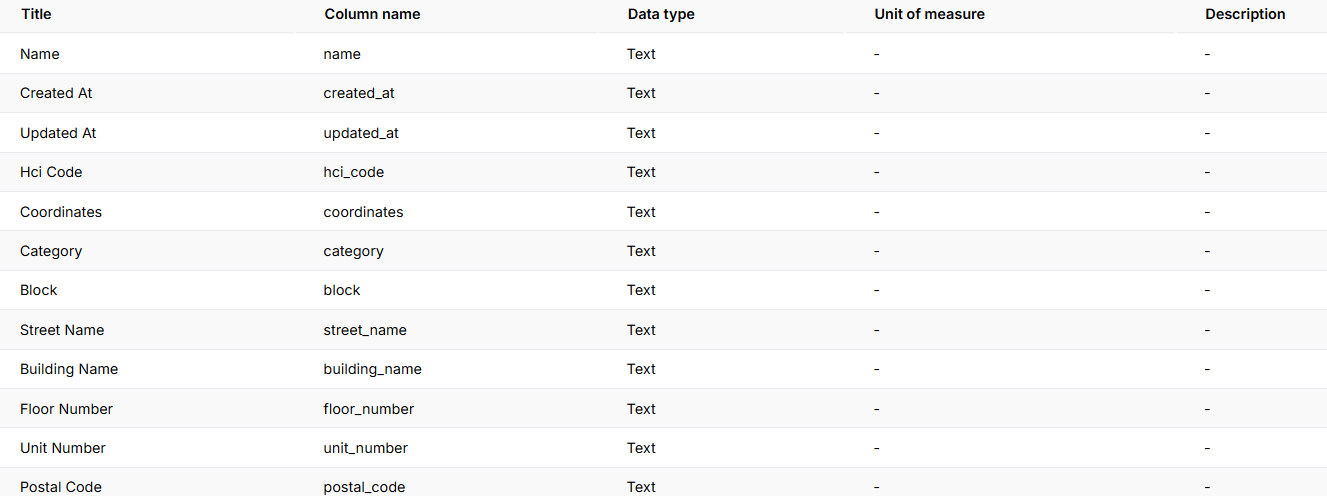

- Citation:

  Open Government Products, 2024, "Clinics onboard the Health Appointment System", data.gov.sg. Accessed: March 20, 2025. [Online]. Available: https://data.gov.sg/datasets/d_3cd840069e95b6a521aa5301a084b25a/view

**Note: Some of the clinics may be closed in real life e.g. Saudara Clinic By A+J General Physicians**

#### Load clinic dataset from `data.gov.sg`

In [5]:
# Define dataset ID and URL
dataset_id = "d_3cd840069e95b6a521aa5301a084b25a"
url = "https://data.gov.sg/api/action/datastore_search?resource_id=" + dataset_id

# Initialize an empty list to hold all records
all_clinic_records = []

# Set the initial offset and limit
limit = 100  # Max records per request
offset = 0

# Loop through the paginated data as the API only returns 100 records per request
while True:
    # Send a request with the limit and offset
    response = requests.get(f"{url}&limit={limit}&offset={offset}")

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        records = data["result"]["records"]

        # Add the records to the list
        all_clinic_records.extend(records)

        # Check if there are more records (if the number of records returned is less than the limit, stop)
        if len(records) < limit:
            break

        # Update offset for the next batch of records
        offset += limit
    else:
        print(f"Request failed with status code {response.status_code}")
        break

# Convert the list of all records to a pandas DataFrame
clinic_df = pd.DataFrame(all_clinic_records)

In [6]:
# ------------------
# Data Understanding
# ------------------
print(f"Columns: {clinic_df.columns.tolist()}\n")
print(f"Clinic Count: {len(clinic_df)}\n")
print(f"Clinic Types: \n{clinic_df['category'].value_counts()}")

Columns: ['_id', 'name', 'created_at', 'updated_at', 'hci_code', 'coordinates', 'category', 'block', 'street_name', 'building_name', 'floor_number', 'unit_number', 'postal_code']

Clinic Count: 1600

Clinic Types: 
category
gp                 1515
law-firm             53
non-chas-gp          17
nhg-polyclinic       11
nuhs-polyclinic       4
Name: count, dtype: int64


### **OneMap API**


OneMap is Singapore's authoritative, most comprehensive and detailed map of Singapore.

API Document Link: https://www.onemap.gov.sg/apidocs/search

The API allows users to obtain address information for roads and buildings, etc. It akes a text input which can be a building name, road name, bus stop number, or postal code; for example: "Revenue House" or "307987". It returns address information including both latitude, longitude, and x, y coordinates, based on the text input and sorts the results according to their estimated relevance.

In [7]:
def get_address_info(text_input):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={text_input}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    headers = {"Authorization": "Bearer **********************"}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        if data["found"] > 0:  # If postal code exists in OneMap
            result = data["results"][0]
            return {
                "postal_code": result["POSTAL"],
                "address": result[
                    "ADDRESS"
                ],  # f"{(result['BLK_NO'] if result['BLK_NO'] != 'NIL' else '')} {(result['ROAD_NAME'] if result['ROAD_NAME'] != 'NIL' else '')} {(result['BUILDING'] if result['BUILDING'] != 'NIL' else '')}",
                "latitude": result["LATITUDE"],
                "longitude": result["LONGITUDE"],
            }
    return None  # Invalid postal code

<hr>

## Polyclinics Table


In [8]:
# Fliter for polyclinics
polyclinics_df = institutions_df[
    institutions_df["GroupName"] == "Polyclinics"
].reset_index()  # 26 polyclinics

# ----------
# Data Check
# ----------
print(f"Polyclinic Count: {len(polyclinics_df)}")
# There may be different outlets across Singapore
print(f"Unique Polyclinic Name Count: {len(polyclinics_df['Name'].unique())}")

include_columns = ["Name"]
polyclinics_df = polyclinics_df[include_columns]

# Get Postal Code & Address
polyclinics_df[["postal_code", "address"]] = polyclinics_df["Name"].apply(
    lambda name: (
        pd.Series(get_address_info(name), index=["postal_code", "address"])
        if get_address_info(name)
        else pd.Series([None, None], index=["postal_code", "address"])
    )
)

# Update incorrectly identified postal code(s)
update_postal_code = {"Sembawang Polyclinic": "756973"}
for polyclinic, postal_code in update_postal_code.items():
    polyclinics_df.loc[polyclinics_df["Name"] == polyclinic, "postal_code"] = (
        postal_code
    )

# Drop address column
polyclinics_df = polyclinics_df.drop(columns=["address"])
display(polyclinics_df)

Polyclinic Count: 26
Unique Polyclinic Name Count: 26


,Name,postal_code
0,Ang Mo Kio Polyclinic,569666
1,Geylang Polyclinic,389707
2,Hougang Polyclinic,538829
3,Kallang Polyclinic,328263
4,Khatib Polyclinic,769567
5,Toa Payoh Polyclinic,319260
6,Sembawang Polyclinic,756973
7,Woodlands Polyclinic,738579
8,Yishun Polyclinic,768898
9,Bukit Batok Polyclinic,659164


In [9]:
# Generate the polyclinics_data dictionary using existing data
current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Generate the polyclinics_data dictionary using existing data
polyclinics_data = {
    "id": [
        i for i in range(1, len(polyclinics_df) + 1)
    ],  # Create a unique ID for each polyclinic
    "name": polyclinics_df["Name"].tolist(),
    "postal_code": polyclinics_df["postal_code"].tolist(),
    "created_at": [current_timestamp] * len(polyclinics_df),
    "updated_at": [current_timestamp] * len(polyclinics_df),
}
# Convert to DataFrame
polyclinics_df = pd.DataFrame(polyclinics_data)
# Get list of unique polyclinic postal_code
polyclinic_postal_code = polyclinics_df["postal_code"].drop_duplicates().tolist()
display(polyclinics_df)

,id,name,postal_code,created_at,updated_at
0,1,Ang Mo Kio Polyclinic,569666,2025-03-24 13:36:07,2025-03-24 13:36:07
1,2,Geylang Polyclinic,389707,2025-03-24 13:36:07,2025-03-24 13:36:07
2,3,Hougang Polyclinic,538829,2025-03-24 13:36:07,2025-03-24 13:36:07
3,4,Kallang Polyclinic,328263,2025-03-24 13:36:07,2025-03-24 13:36:07
4,5,Khatib Polyclinic,769567,2025-03-24 13:36:07,2025-03-24 13:36:07
5,6,Toa Payoh Polyclinic,319260,2025-03-24 13:36:07,2025-03-24 13:36:07
6,7,Sembawang Polyclinic,756973,2025-03-24 13:36:07,2025-03-24 13:36:07
7,8,Woodlands Polyclinic,738579,2025-03-24 13:36:07,2025-03-24 13:36:07
8,9,Yishun Polyclinic,768898,2025-03-24 13:36:07,2025-03-24 13:36:07
9,10,Bukit Batok Polyclinic,659164,2025-03-24 13:36:07,2025-03-24 13:36:07


## GeneralPractitioners Table


In [10]:
# Get General Practitioners only
gp_api_df = clinic_df[clinic_df["category"].isin(["gp", "non-chas-gp"])]
print(f"GP Count: {len(gp_api_df)}")
# There may be different outlets across Singapore
print(f"Unique GP Name Count: {len(gp_api_df['name'].unique())}")
print(f"Unique GP Postal Code Count: {len(gp_api_df['postal_code'].unique())}")

gp_geo_df = gp_api_df.copy()
# Extract the required columns
columns_to_extract = ["name", "postal_code"]
gp_geo_df = gp_geo_df[columns_to_extract]
# Reset the index of the DataFrame
gp_geo_df.reset_index(drop=True, inplace=True)
gp_geo_df

GP Count: 1532
Unique GP Name Count: 1486
Unique GP Postal Code Count: 1074


,name,postal_code
0,Cavenagh Medical Clinic And Home Care,269695
1,Mei Ling Clinic,140158
2,Rcmc Rivervale Crescent Medical Centre,541182
3,360 Clinic,560407
4,SKY Medical,079027
...,...,...
1527,Trinity Medical@Shenton,068908
1528,Saudara Clinic By A+J General Physicians,419741
1529,Zara Clinic,680026
1530,360 Clinic,640221


In [ ]:
current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Generate the gps_data dictionary using existing data
gps_data = {
    "id": [i for i in range(1, len(gp_geo_df) + 1)],  # Create a unique ID for each gp
    "name": gp_geo_df["name"].tolist(),
    "postal_code": gp_geo_df["postal_code"].tolist(),
    "created_at": [current_timestamp] * len(gp_geo_df),
    "updated_at": [current_timestamp] * len(gp_geo_df),
}
# Convert to DataFrame
gps_df = pd.DataFrame(gps_data)
# Get list of unique gp postal_code
gps_postal_code = gps_df["postal_code"].drop_duplicates().tolist()
display(gps_df)

,id,name,postal_code,created_at,updated_at
0,1,Cavenagh Medical Clinic And Home Care,269695,2025-03-24 13:36:52,2025-03-24 13:36:52
1,2,Mei Ling Clinic,140158,2025-03-24 13:36:52,2025-03-24 13:36:52
2,3,Rcmc Rivervale Crescent Medical Centre,541182,2025-03-24 13:36:52,2025-03-24 13:36:52
3,4,360 Clinic,560407,2025-03-24 13:36:52,2025-03-24 13:36:52
4,5,SKY Medical,079027,2025-03-24 13:36:52,2025-03-24 13:36:52
...,...,...,...,...,...
1527,1528,Trinity Medical@Shenton,068908,2025-03-24 13:36:52,2025-03-24 13:36:52
1528,1529,Saudara Clinic By A+J General Physicians,419741,2025-03-24 13:36:52,2025-03-24 13:36:52
1529,1530,Zara Clinic,680026,2025-03-24 13:36:52,2025-03-24 13:36:52
1530,1531,360 Clinic,640221,2025-03-24 13:36:52,2025-03-24 13:36:52


In [12]:
# Unique postal_code from Polyclinics and GPs
clinic_postal_code = polyclinic_postal_code + gps_postal_code
print(f"Clinic Postal Code Count: {len(clinic_postal_code)}")

Clinic Postal Code Count: 1100


In [13]:
len(clinic_postal_code)

1100

## Users Table


In [15]:
# Regex pattern for nric
nric_regex = r"[STFGM]\d{7}[A-Z]"


def generate_nric(dob):
    year = dob.year
    year_suffix = str(year % 100).zfill(2)  # Extract last two digits of the year
    serial_number = str(random.randint(10000, 99999))  # Ensure exactly 7 digits
    checksum = random.choice("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # Random letter for checksum

    # Determine prefix based on birth year
    prefix = "S" if year < 2000 else "T"

    sample_nric = f"{prefix}{year_suffix}{serial_number}{checksum}"

    # Validate against regex before returning
    if not re.fullmatch(nric_regex, sample_nric):
        raise ValueError(
            f"Generated nric '{sample_nric}' does not match expected pattern."
        )

    return sample_nric


def generate_email(first_name, last_name):
    email_username = f"{first_name.lower()}.{last_name.lower()}"
    email_domain = fake.free_email_domain()  # Use a real email domain
    return f"{email_username}@{email_domain}"

In [27]:
N = 200

ids = []
nrics = []
first_names = []
last_names = []
emails = []
date_of_births = []
genders = []
current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

for i in range(N):
    gender = np.random.choice(["M", "F"], p=[0.5, 0.5])
    first_name = fake.first_name_male() if gender == "M" else fake.first_name_female()
    last_name = fake.last_name_male() if gender == "M" else fake.last_name_female()
    email = (
        first_name.lower() + "." + last_name.lower() + "@" + fake.email().split("@")[1]
    )
    date_of_birth = fake.date_of_birth(minimum_age=18, maximum_age=80)
    nric = generate_nric(date_of_birth)

    ids.append(i + 1)
    nrics.append(nric)
    first_names.append(first_name)
    last_names.append(last_name)
    emails.append(email)
    date_of_births.append(date_of_birth)
    genders.append(gender)

# Users Table
users_data = {
    "id": ids,
    "nric": nrics,
    "first_name": first_names,
    "last_name": last_names,
    "email": emails,
    "date_of_birth": date_of_births,
    "gender": genders,
}

users_df = pd.DataFrame(users_data)
display(users_df)

,id,nric,first_name,last_name,email,date_of_birth,gender
0,1,S7955661K,Angela,Lucas,angela.lucas@example.com,1979-11-21,F
1,2,S9082146L,Joseph,Moore,joseph.moore@example.com,1990-06-05,M
2,3,S7032490L,Kyle,Mccormick,kyle.mccormick@example.net,1970-07-14,M
3,4,T0697024S,Diane,Cummings,diane.cummings@example.org,2006-08-11,F
4,5,S6578783G,Gregory,Ponce,gregory.ponce@example.org,1965-04-17,M
...,...,...,...,...,...,...,...
195,196,S5275429Z,Anna,Estes,anna.estes@example.net,1952-11-10,F
196,197,S7098857O,Michael,Anderson,michael.anderson@example.net,1970-12-13,M
197,198,S8774937A,Katherine,Ray,katherine.ray@example.org,1987-05-06,F
198,199,T0345421R,Rebecca,Mack,rebecca.mack@example.net,2003-12-05,F


In [28]:
# -----------------------------
# Perform Checks on Users Table
# -----------------------------
# Verify all nrics match the expected pattern
if all(re.fullmatch(nric_regex, nric) for nric in users_df["nric"]):
    print("All nrics match the expected format.")
else:
    print("Some nrics do not match the expected format.")
    print(
        users_df.loc[~users_df["nric"].str.match(nric_regex), ["nric"]]
    )  # Show incorrect nrics

# Combine first name and last name into a full name for checking uniqueness
check_fullName = users_df["first_name"] + " " + users_df["last_name"]
# Check that the full names are all unique
print(f"Number of unique full names: {check_fullName.nunique()}")

# Check that dates are in range
start_date = "1920-01-01"
end_date = "2025-03-01"

users_df["date_of_birth"] = pd.to_datetime(users_df["date_of_birth"])
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

is_in_range = (users_df["date_of_birth"] >= start_date) & (
    users_df["date_of_birth"] <= end_date
)

# Check if the date is under range
if is_in_range.all():
    print("All date are in range")
else:
    print("Some dates are not in range")

All nrics match the expected format.
Number of unique full names: 200
All date are in range


In [29]:
# To get postal codes for Users, either:
# (1) Load the postal codes from the .txt file, given that it was previously ran and saved
with open("postal_codes.txt", "r") as file:
    valid_postal_codes = [line.strip() for line in file.readlines()]

print(valid_postal_codes)
# Convert to actual dictionary
valid_postal_codes = [ast.literal_eval(entry) for entry in valid_postal_codes]

["{'postal_code': '597245', 'address': '6A SUNSET VALE SINGAPORE 597245', 'latitude': '1.32916492200213', 'longitude': '103.768880413609'}", "{'postal_code': '589603', 'address': '9 JALAN ANAK BUKIT THE RESERVE RESIDENCES SINGAPORE 589603', 'latitude': '1.33991958805043', 'longitude': '103.776935231106'}", "{'postal_code': '576167', 'address': '11 ORCHID DRIVE ADELPHI PARK ESTATE SINGAPORE 576167', 'latitude': '1.35511540506355', 'longitude': '103.82901701112'}", "{'postal_code': '575835', 'address': '21 SERAYA CRESCENT SEMBAWANG HILLS ESTATE SINGAPORE 575835', 'latitude': '1.37327032575504', 'longitude': '103.827232710718'}", "{'postal_code': '520144', 'address': '144 SIMEI STREET 2 SINGAPORE 520144', 'latitude': '1.34535129708528', 'longitude': '103.95557026414'}", "{'postal_code': '279311', 'address': '74 GREENLEAF VIEW BAN GUAN PARK SINGAPORE 279311', 'latitude': '1.32227236994635', 'longitude': '103.787360183072'}", "{'postal_code': '554705', 'address': '6 CHUAN LINK SINGAPORE 554

In [81]:
# # ------------------------------------------------------------------------------------
# # (2) Generate postal codes in Users Table that are different from clinic postal codes
# # Runtime: ~16mins
# # ------------------------------------------------------------------------------------
# valid_postal_codes = []
# checked_codes = set()

# while len(valid_postal_codes) < 200:
#     random_code = str(
#         random.randint(100000, 999999)
#     )  # Generate random 6-digit postal code

#     if random_code in clinic_postal_code or random_code in checked_codes:
#         continue  # Skip if already checked or is a clinic postal code

#     checked_codes.add(random_code)
#     geoData = get_address_info(random_code)

#     if geoData:
#         valid_postal_codes.append(geoData)
#         print(
#             f"Valid: {random_code} (Lat: {geoData['latitude']}, Lon: {geoData['longitude']}), Address: {geoData['address']}"
#         )

#     time.sleep(0.5)  # Sleep to prevent hitting API rate limits

# # Display final list of 200 real postal codes
# print(valid_postal_codes)

# # Write postal codes to a .txt file for faster setup next time
# with open("postal_codes.txt", "w") as file:
#     for code in valid_postal_codes:
#         file.write(f"{code}\n")

In [30]:
# Create new `postal_code` column in Users Table
print(
    f"Users Count: {len(users_df)}, Generated User Postal Codes: {len(valid_postal_codes)}"
)
users_postal_codes = [int(entry["postal_code"]) for entry in valid_postal_codes]

users_df["postal_code"] = users_postal_codes

current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
users_df = users_df.assign(created_at=current_timestamp, updated_at=current_timestamp)

display(users_df)

Users Count: 200, Generated User Postal Codes: 200


,id,nric,first_name,last_name,email,date_of_birth,gender,postal_code,created_at,updated_at
0,1,S7955661K,Angela,Lucas,angela.lucas@example.com,1979-11-21,F,597245,2025-03-24 13:46:43,2025-03-24 13:46:43
1,2,S9082146L,Joseph,Moore,joseph.moore@example.com,1990-06-05,M,589603,2025-03-24 13:46:43,2025-03-24 13:46:43
2,3,S7032490L,Kyle,Mccormick,kyle.mccormick@example.net,1970-07-14,M,576167,2025-03-24 13:46:43,2025-03-24 13:46:43
3,4,T0697024S,Diane,Cummings,diane.cummings@example.org,2006-08-11,F,575835,2025-03-24 13:46:43,2025-03-24 13:46:43
4,5,S6578783G,Gregory,Ponce,gregory.ponce@example.org,1965-04-17,M,520144,2025-03-24 13:46:43,2025-03-24 13:46:43
...,...,...,...,...,...,...,...,...,...,...
195,196,S5275429Z,Anna,Estes,anna.estes@example.net,1952-11-10,F,728787,2025-03-24 13:46:43,2025-03-24 13:46:43
196,197,S7098857O,Michael,Anderson,michael.anderson@example.net,1970-12-13,M,218601,2025-03-24 13:46:43,2025-03-24 13:46:43
197,198,S8774937A,Katherine,Ray,katherine.ray@example.org,1987-05-06,F,519936,2025-03-24 13:46:43,2025-03-24 13:46:43
198,199,T0345421R,Rebecca,Mack,rebecca.mack@example.net,2003-12-05,F,118926,2025-03-24 13:46:43,2025-03-24 13:46:43


## Address Table


In [20]:
# List of all postal codes
clinic_users_postal_code = (
    clinic_postal_code + users_postal_codes
)  # 200 (users) + 26 (polyclinics) + 1074 (gps) = 1300 postal_codes expected

# Convert to DataFrame for better visualization
postal_code_df = pd.DataFrame({"postal_code": clinic_postal_code + users_postal_codes})

# Count occurrences
duplicate_counts = postal_code_df["postal_code"].value_counts()

# Filter postal_code duplicates
duplicates_postal_code_df = duplicate_counts[duplicate_counts > 1]
duplicates_postal_code_lisit = duplicates_postal_code_df.index.tolist()
print(duplicates_postal_code_df)
print(f"\nGPS: \n{gps_df[gps_df['postal_code'].isin(duplicates_postal_code_lisit)]}\n")
print(
    f"Polyclinics: \n{polyclinics_df[polyclinics_df['postal_code'].isin(duplicates_postal_code_lisit)]}\n"
)
print(
    f"Users: \n{users_df[users_df['postal_code'].isin(duplicates_postal_code_lisit)]}\n"
)

postal_code
820681    2
469662    2
150163    2
120451    2
Name: count, dtype: int64

GPS: 
      id                                      name postal_code  \
144  145              Drs. Koo, Koh and Associates      150163   
193  194   Parkway Shenton Medical Group (Punggol)      820681   
635  636       1doc Medical Centre Heartbeat@Bedok      469662   
685  686  Parkway Shenton Medical Group (Clementi)      120451   

              created_at           updated_at  
144  2025-03-24 13:36:52  2025-03-24 13:36:52  
193  2025-03-24 13:36:52  2025-03-24 13:36:52  
635  2025-03-24 13:36:52  2025-03-24 13:36:52  
685  2025-03-24 13:36:52  2025-03-24 13:36:52  

Polyclinics: 
    id                    name postal_code           created_at  \
13  14     Clementi Polyclinic      120451  2025-03-24 13:36:07   
16  17        Bedok Polyclinic      469662  2025-03-24 13:36:07   
17  18  Bukit Merah Polyclinic      150163  2025-03-24 13:36:07   
23  24      Punggol Polyclinic      820681  2025-03-2

In [ ]:
# List of all postal codes
clinic_users_postal_code = (
    clinic_postal_code + users_postal_codes
)  # 200 (users) + 26 (polyclinics) + 1074 (gps) = 1300 postal_codes (expected) - 4 (duplicates) = 1296 postal_codes
# Drop duplicate postal_codes
clinic_users_postal_code = list(dict.fromkeys(clinic_users_postal_code))

# Get the geo data from OneMap API, runtime: ~2mins
addresses_data = [
    get_address_info(postal_code) for postal_code in clinic_users_postal_code
]

# Convert to DataFrame
addresses_df = pd.DataFrame(addresses_data)

# Create 'id` column`
addresses_count = len(addresses_df)
addresses_df["id"] = [i for i in range(1, addresses_count + 1)]
# Insert 'id' as the first column
addresses_df.insert(0, "id", addresses_df.pop("id"))

current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
addresses_df = addresses_df.assign(
    created_at=current_timestamp, updated_at=current_timestamp
)

display(addresses_df)

,id,postal_code,address,latitude,longitude,created_at,updated_at
0,1,569666,21 ANG MO KIO CENTRAL 2 ANG MO KIO POLYCLINIC ...,1.3743245905856,103.845677779279,2025-03-24 13:40:31,2025-03-24 13:40:31
1,2,389707,21 GEYLANG EAST CENTRAL GEYLANG POLYCLINIC SIN...,1.31949365581957,103.887166041622,2025-03-24 13:40:31,2025-03-24 13:40:31
2,3,538829,89 HOUGANG AVENUE 4 HOUGANG POLYCLINIC SINGAPO...,1.3699068381066,103.88900146446,2025-03-24 13:40:31,2025-03-24 13:40:31
3,4,328263,701 SERANGOON ROAD KALLANG POLYCLINIC AND LONG...,1.31678496747374,103.858752270079,2025-03-24 13:40:31,2025-03-24 13:40:31
4,5,769567,690 YISHUN RING ROAD KHATIB POLYCLINIC SINGAPO...,1.41820402220914,103.834428037791,2025-03-24 13:40:31,2025-03-24 13:40:31
...,...,...,...,...,...,...,...
1291,1292,728787,32 SUNGEI KADUT WAY HUA KOK INDUSTRIAL BUILDIN...,1.40664878570127,103.753025253834,2025-03-24 13:40:31,2025-03-24 13:40:31
1292,1293,218601,158 RACE COURSE ROAD SINGAPORE 218601,1.31037742043094,103.852688922685,2025-03-24 13:40:31,2025-03-24 13:40:31
1293,1294,519936,511A ELIAS ROAD SINGAPORE 519936,1.3807527338979,103.947562413466,2025-03-24 13:40:31,2025-03-24 13:40:31
1294,1295,118926,31 PASIR PANJANG DRIVE EALINE PARK SINGAPORE 1...,1.29229219697385,103.771242630575,2025-03-24 13:40:31,2025-03-24 13:40:31


## Vaccines Table


In Singapore, there is the National Childhood Immnisation Schedule and National Adult Immunisation Schedule, which consits of nationally recommended vaccines for children and adults respectively.

Resource: https://www.moh.gov.sg/seeking-healthcare/overview-of-diseases/communicable-diseases/nationally-recommended-vaccines

In [23]:
current_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Vaccine Table
vaccines_data = {
    "id": [i for i in range(1, 8)],
    "name": [  # Adult Vaccines
        "Influenza (INF)",
        "Pneumococcal Conjugate (PCV13)",
        "Human Papillomavirus (HPV)",
        "Tetanus, Diphtheria, Pertussis (Tdap)",
        "Hepatitis B (HepB)",
        "Measles, Mumps, Rubella (MMR)",
        "Varicella (VAR)",
    ],
    "price": [9.0, 16.0, 23.0, 10.0, 9.0, 9.0, 11.0],
    "doses_required": [1, 1, 3, 1, 3, 2, 2],
    "age_criteria": [
        "18+ years old",
        "65+ years old",
        "18-26 years old",
        "18+ years old",
        "18+ years old",
        "18+ years old",
        "18+ years old",
    ],
    "gender_criteria": [
        "None",
        "None",
        "F",
        "F",
        "None",
        "None",
        "None",
    ],
    "created_at": [current_timestamp] * 7,
    "updated_at": [current_timestamp] * 7,
    # condition_crietria
}
vaccines_df = pd.DataFrame(vaccines_data)
display(vaccines_df)

,id,name,price,doses_required,age_criteria,gender_criteria,created_at,updated_at
0,1,Influenza (INF),9.0,1,18+ years old,None,2025-03-24 13:43:38,2025-03-24 13:43:38
1,2,Pneumococcal Conjugate (PCV13),16.0,1,65+ years old,None,2025-03-24 13:43:38,2025-03-24 13:43:38
2,3,Human Papillomavirus (HPV),23.0,3,18-26 years old,F,2025-03-24 13:43:38,2025-03-24 13:43:38
3,4,"Tetanus, Diphtheria, Pertussis (Tdap)",10.0,1,18+ years old,F,2025-03-24 13:43:38,2025-03-24 13:43:38
4,5,Hepatitis B (HepB),9.0,3,18+ years old,None,2025-03-24 13:43:38,2025-03-24 13:43:38
5,6,"Measles, Mumps, Rubella (MMR)",9.0,2,18+ years old,None,2025-03-24 13:43:38,2025-03-24 13:43:38
6,7,Varicella (VAR),11.0,2,18+ years old,None,2025-03-24 13:43:38,2025-03-24 13:43:38


## BookingSlots Table


In [24]:
# 1 day: 5 slots
# 1 month (20 working days): 5 * 20 = 100
# 26 polyclincs: 100 * 26 = 2600

# Define the start and end dates for the range
start_date = datetime(2025, 3, 1)
end_date = datetime(2025, 3, 31)

N = 2600

ids = []
polyclinic_ids = []
vaccine_ids = []
datetimes = []

for i in range(N):
    polyclinic_id = random.choice(polyclinics_data["id"])
    vaccine_id = random.choice(vaccines_data["id"])
    datetime = (
        start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
    ).replace(
        hour=random.randint(9, 18),  # Random hour between 9 AM and 6 PM
        minute=0,  # Set minute to 0 for hourly slots
        second=0,  # Set second to 0
        microsecond=0,  # Set microsecond to 0
    )

    ids.append(i + 1)
    polyclinic_ids.append(polyclinic_id)
    vaccine_ids.append(vaccine_id)
    datetimes.append(datetime)

# Booking Slots Table
booking_slots_data = {
    "id": ids,
    "polyclinic_id": polyclinic_ids,
    "vaccine_id": vaccine_ids,
    "datetime": datetimes,
    "created_at": [current_timestamp] * N,
    "updated_at": [current_timestamp] * N,
}

booking_slots_df = pd.DataFrame(booking_slots_data)
display(booking_slots_df)

,id,polyclinic_id,vaccine_id,datetime,created_at,updated_at
0,1,6,2,2025-03-24 10:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
1,2,6,4,2025-03-22 15:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
2,3,6,1,2025-03-03 13:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
3,4,1,6,2025-03-11 16:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
4,5,24,6,2025-03-07 12:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
...,...,...,...,...,...,...
2595,2596,13,6,2025-03-04 11:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
2596,2597,15,1,2025-03-24 11:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
2597,2598,19,3,2025-03-28 09:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38
2598,2599,20,7,2025-03-29 17:00:00,2025-03-24 13:43:38,2025-03-24 13:43:38


## VaccineRecords Table

To be updated to represent actual system

In [25]:
# Users count: 200
# Vaccines count: 7
# Users * Vaccines = 1400

vaccineRecords_count = 500

# Vaccine Records Table
vaccine_records_data = {
    "id": [i for i in range(1, vaccineRecords_count + 1)],
    "user_nric": [
        random.choice(users_data["nric"]) for _ in range(vaccineRecords_count)
    ],
    "booking_slot_id": [
        np.random.choice(booking_slots_data["id"], replace=False)
        for _ in range(vaccineRecords_count)
    ],
    "status": [
        random.choice(["booked", "completed"]) for _ in range(vaccineRecords_count)
    ],
    "created_at": [current_timestamp] * vaccineRecords_count,
    "updated_at": [current_timestamp] * vaccineRecords_count,
}
vaccine_records_df = pd.DataFrame(vaccine_records_data)
display(vaccine_records_df)

,id,user_nric,booking_slot_id,status,created_at,updated_at
0,1,S6390662A,1588,completed,2025-03-24 13:43:38,2025-03-24 13:43:38
1,2,T0570923U,80,booked,2025-03-24 13:43:38,2025-03-24 13:43:38
2,3,S9712597A,2263,completed,2025-03-24 13:43:38,2025-03-24 13:43:38
3,4,S6755985U,1837,booked,2025-03-24 13:43:38,2025-03-24 13:43:38
4,5,T0660227G,1921,booked,2025-03-24 13:43:38,2025-03-24 13:43:38
...,...,...,...,...,...,...
495,496,S8425566K,2196,completed,2025-03-24 13:43:38,2025-03-24 13:43:38
496,497,S7946123J,1735,booked,2025-03-24 13:43:38,2025-03-24 13:43:38
497,498,S7530136C,136,completed,2025-03-24 13:43:38,2025-03-24 13:43:38
498,499,S5342767B,2010,booked,2025-03-24 13:43:38,2025-03-24 13:43:38


## VaccineStockInventory Table (excluded)


In [88]:
# # Polyclinics count: 13
# # Vaccines count: 7
# # Number of recrods: Polyclinics * Vaccines = 91

# # Assumming vaccines are not avaliable at all polyclinics
# total_records = 80

# # Vaccine Stock Inventory Table
# vaccine_stock_data = {
#     "id": [],
#     "polyclinic_id": [],
#     "vaccine_id": [],
#     "stock_quantity": [],
# }

# # Initialize a set to track unique (polyclinic_id, vaccine_id) combinations
# existing_combinations = set()

# id_counter = 1

# # Loop to create 200 records with random vaccine availability
# while len(vaccine_stock_data["polyclinic_id"]) < total_records:
#     polyclinic = random.choice(polyclinics_df["id"])  # Randomly choose a polyclinic
#     available_vaccines = random.sample(
#         vaccines_df["id"].tolist(), random.randint(1, len(vaccines_df))
#     )  # Randomly pick some vaccines for the polyclinic

#     for vaccine in available_vaccines:
#         # Ensure the (polyclinic_id, vaccine_id) combination is unique
#         combination = (polyclinic, vaccine)
#         if combination not in existing_combinations:
#             vaccine_stock_data["id"].append(id_counter)
#             vaccine_stock_data["polyclinic_id"].append(polyclinic)  # Polyclinic ID
#             vaccine_stock_data["vaccine_id"].append(vaccine)  # Vaccine ID
#             vaccine_stock_data["stock_quantity"].append(
#                 random.randint(50, 200)
#             )  # Random stock quantity
#             existing_combinations.add(combination)  # Track the combination
#             id_counter += 1  # Increment ID

# # Convert to DataFrame
# vaccine_stock_df = pd.DataFrame(vaccine_stock_data)
# # Display the resulting DataFrame
# display(vaccine_stock_df)

In [89]:
# # ----------
# # Check data
# # ----------
# # Group the dataframe by polyclinic_id and vaccine_id and count occurrences
# grouped = (
#     vaccine_stock_df.groupby(["polyclinic_id", "vaccine_id"])
#     .size()
#     .reset_index(name="count")
# )

# # Check if any combination appears more than once
# duplicates = grouped[grouped["count"] > 1]

# # Display the duplicates if any
# if not duplicates.empty:
#     print("Found duplicate entries:")
#     display(duplicates)
# else:
#     print("All polyclinic_id and vaccine_id combinations are unique.")

## Final Column Dtype Check

In [32]:
# Check column dtype


def check_col_dtype(df):
    df_columns = df.columns.tolist()
    for idx, row in df.iterrows():
        i = 0
        for col in row:
            print(f"{df_columns[i]}: {type(col)}")
            i += 1
        break


dataframes = [
    users_df,
    polyclinics_df,
    gps_df,
    addresses_df,
    vaccines_df,
    vaccine_records_df,
    # vaccine_stock_df,
    booking_slots_df,
]
dataframe_names = [
    "Users",
    "Polyclinics",
    "GeneralPractitioners",
    "Addresses",
    "Vaccines",
    "VaccineRecords",
    # "VaccineStockInventory",
    "BookingSlots",
]
counter = 0
print("Check the column dtypes in each table:\n")
for df in dataframes:
    print(f"*********************\n{dataframe_names[counter]}\n*********************")
    check_col_dtype(df)
    print("")
    counter += 1

Check the column dtypes in each table:

*********************
Users
*********************
id: <class 'int'>
nric: <class 'str'>
first_name: <class 'str'>
last_name: <class 'str'>
email: <class 'str'>
date_of_birth: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
gender: <class 'numpy.str_'>
postal_code: <class 'int'>
created_at: <class 'str'>
updated_at: <class 'str'>

*********************
Polyclinics
*********************
id: <class 'int'>
name: <class 'str'>
postal_code: <class 'str'>
created_at: <class 'str'>
updated_at: <class 'str'>

*********************
GeneralPractitioners
*********************
id: <class 'int'>
name: <class 'str'>
postal_code: <class 'str'>
created_at: <class 'str'>
updated_at: <class 'str'>

*********************
Addresses
*********************
id: <class 'int'>
postal_code: <class 'str'>
address: <class 'str'>
latitude: <class 'str'>
longitude: <class 'str'>
created_at: <class 'str'>
updated_at: <class 'str'>

*********************
Vaccines
*************

## Insert Vaccination Data into SQLite Database

Delete the existing SQLite file before running the cell below to avoid appending to old SQLite database.

In [33]:
# Define SQLite database file path again
sqlite_db_path = "../data/vaccination_db.sqlite"

# Reconnect to SQLite database
conn = sqlite3.connect(sqlite_db_path)
cursor = conn.cursor()


# Function to insert DataFrame data into SQLite
def insert_csv_to_sqlite(
    csv_data: pd.DataFrame, table_name: str, conn: sqlite3.Connection
):
    csv_data.to_sql(table_name, conn, if_exists="append", index=False)


# Insert data into SQLite tables
insert_csv_to_sqlite(users_df, "Users", conn)
insert_csv_to_sqlite(polyclinics_df, "Polyclinics", conn)
insert_csv_to_sqlite(gps_df, "GeneralPractitioners", conn)
insert_csv_to_sqlite(addresses_df, "Addresses", conn)
insert_csv_to_sqlite(vaccines_df, "Vaccines", conn)
insert_csv_to_sqlite(vaccine_records_df, "VaccineRecords", conn)
# insert_csv_to_sqlite(vaccine_stock_df, "VaccineStockInventory", conn)
insert_csv_to_sqlite(booking_slots_df, "BookingSlots", conn)

# Commit changes and close connection
conn.commit()
conn.close()

## Query SQLite Database

In [34]:
conn = sqlite3.connect("../data/vaccination_db.sqlite")
cursor = conn.cursor()

In [35]:
# Example: Fetch all users
cursor.execute("SELECT * FROM Users")
rows = cursor.fetchall()
for row in rows:
    print(row)

conn.close()

(1, 'S7955661K', 'Angela', 'Lucas', 'angela.lucas@example.com', '1979-11-21 00:00:00', 'F', 597245, '2025-03-24 13:46:43', '2025-03-24 13:46:43')
(2, 'S9082146L', 'Joseph', 'Moore', 'joseph.moore@example.com', '1990-06-05 00:00:00', 'M', 589603, '2025-03-24 13:46:43', '2025-03-24 13:46:43')
(3, 'S7032490L', 'Kyle', 'Mccormick', 'kyle.mccormick@example.net', '1970-07-14 00:00:00', 'M', 576167, '2025-03-24 13:46:43', '2025-03-24 13:46:43')
(4, 'T0697024S', 'Diane', 'Cummings', 'diane.cummings@example.org', '2006-08-11 00:00:00', 'F', 575835, '2025-03-24 13:46:43', '2025-03-24 13:46:43')
(5, 'S6578783G', 'Gregory', 'Ponce', 'gregory.ponce@example.org', '1965-04-17 00:00:00', 'M', 520144, '2025-03-24 13:46:43', '2025-03-24 13:46:43')
(6, 'S8931611O', 'Justin', 'Schneider', 'justin.schneider@example.net', '1989-11-07 00:00:00', 'M', 279311, '2025-03-24 13:46:43', '2025-03-24 13:46:43')
(7, 'S5730667G', 'Jay', 'Cox', 'jay.cox@example.com', '1957-04-17 00:00:00', 'M', 554705, '2025-03-24 13:4

In [36]:
db_filename = "../data/vaccination_db.sqlite"

try:
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = [row[0] for row in cursor.fetchall()]

    print("Tables in the database:")
    for table_name in table_names:
        print(table_name)

except sqlite3.Error as e:
    print(f"An error occurred: {e}")

finally:
    if conn:
        conn.close()

Tables in the database:
Users
Polyclinics
GeneralPractitioners
Addresses
Vaccines
VaccineRecords
BookingSlots
